In [1]:
# Install required packages
!pip install pandas matplotlib scikit-learn seaborn

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

print("✅ Packages installed successfully!")

✅ Packages installed successfully!


In [7]:
# Load your YouTube data
train_data = pd.read_csv('train_lyst1717074532669.csv')
test_data = pd.read_csv('test_lyst1717074532669.csv')

print("📊 Train data shape:", train_data.shape)
print("📊 Test data shape:", test_data.shape)

print("\n🔍 Training data columns:")
print(train_data.columns.tolist())

print("\n📋 First 3 rows of training data:")
print(train_data.head(3))

print("\n🎯 Target variable 'adview' distribution:")
print(train_data['adview'].value_counts().head())

print(f"\n📐 Data types:")
print(train_data.dtypes)

📊 Train data shape: (14999, 9)
📊 Test data shape: (8764, 8)

🔍 Training data columns:
['vidid', 'adview', 'views', 'likes', 'dislikes', 'comment', 'published', 'duration', 'category']

📋 First 3 rows of training data:
       vidid  adview    views likes dislikes comment   published duration  \
0  VID_18655      40  1031602  8523      363    1095  2016-09-14  PT7M37S   
1  VID_14135       2     1707    56        2       6  2016-10-01  PT9M30S   
2   VID_2187       1     2023    25        0       2  2016-07-02  PT2M16S   

  category  
0        F  
1        D  
2        C  

🎯 Target variable 'adview' distribution:
adview
1    6397
2    2232
3    1106
4     769
5     509
Name: count, dtype: int64

📐 Data types:
vidid        object
adview        int64
views        object
likes        object
dislikes     object
comment      object
published    object
duration     object
category     object
dtype: object


In [9]:
print("🔄 Preprocessing data...")

# Create copies
train_df = train_data.copy()
test_df = test_data.copy()

# Convert numeric columns properly
numeric_columns = ['views', 'likes', 'dislikes', 'comment', 'adview']

print("Converting numeric columns...")
for col in numeric_columns:
    if col in train_df.columns:
        train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    if col in test_df.columns:
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

# Fill NaN values
train_df[numeric_columns] = train_df[numeric_columns].fillna(0)
test_df[['views', 'likes', 'dislikes', 'comment']] = test_df[['views', 'likes', 'dislikes', 'comment']].fillna(0)

print("✅ Numeric conversion completed")

# Convert duration to seconds
def duration_to_seconds(duration):
    try:
        duration = str(duration).upper()
        if 'H' in duration:
            hours = int(duration.split('H')[0].split('T')[1])
            minutes = int(duration.split('H')[1].split('M')[0])
            seconds = int(duration.split('M')[1].split('S')[0])
            return hours * 3600 + minutes * 60 + seconds
        elif 'M' in duration:
            minutes = int(duration.split('M')[0].split('T')[1])
            seconds = int(duration.split('M')[1].split('S')[0])
            return minutes * 60 + seconds
        elif 'S' in duration:
            seconds = int(duration.split('T')[1].split('S')[0])
            return seconds
        else:
            return 0
    except:
        return 0

print("Converting duration to seconds...")
train_df['duration_sec'] = train_df['duration'].apply(duration_to_seconds)
test_df['duration_sec'] = test_df['duration'].apply(duration_to_seconds)

print("Processing publish dates...")
train_df['published'] = pd.to_datetime(train_df['published'], errors='coerce')
test_df['published'] = pd.to_datetime(test_df['published'], errors='coerce')

default_date = pd.Timestamp('2016-01-01')
train_df['published'].fillna(default_date, inplace=True)
test_df['published'].fillna(default_date, inplace=True)

train_df['publish_year'] = train_df['published'].dt.year
train_df['publish_month'] = train_df['published'].dt.month
train_df['publish_day'] = train_df['published'].dt.day

test_df['publish_year'] = test_df['published'].dt.year
test_df['publish_month'] = test_df['published'].dt.month
test_df['publish_day'] = test_df['published'].dt.day

print("Encoding categories...")
label_encoder = LabelEncoder()
train_df['category_encoded'] = label_encoder.fit_transform(train_df['category'])
test_df['category_encoded'] = label_encoder.transform(test_df['category'])

print("Creating engagement metrics...")
train_df['engagement_ratio'] = (train_df['likes'] + train_df['comment']) / (train_df['views'] + 1)
train_df['like_dislike_ratio'] = train_df['likes'] / (train_df['dislikes'] + 1)

test_df['engagement_ratio'] = (test_df['likes'] + test_df['comment']) / (test_df['views'] + 1)
test_df['like_dislike_ratio'] = test_df['likes'] / (test_df['dislikes'] + 1)

# Replace infinite values
train_df = train_df.replace([np.inf, -np.inf], 0)
test_df = test_df.replace([np.inf, -np.inf], 0)

print("✅ Data preprocessing completed!")
print(f"📊 Processed train shape: {train_df.shape}")
print(f"📊 Processed test shape: {test_df.shape}")

print("\n📋 Sample of processed numerical data:")
print(train_df[['views', 'likes', 'dislikes', 'comment', 'duration_sec', 'category_encoded']].head())

🔄 Preprocessing data...
Converting numeric columns...
✅ Numeric conversion completed
Converting duration to seconds...
Processing publish dates...
Encoding categories...
Creating engagement metrics...
✅ Data preprocessing completed!
📊 Processed train shape: (14999, 16)
📊 Processed test shape: (8764, 15)

📋 Sample of processed numerical data:
       views   likes  dislikes  comment  duration_sec  category_encoded
0  1031602.0  8523.0     363.0   1095.0           457                 5
1     1707.0    56.0       2.0      6.0           570                 3
2     2023.0    25.0       0.0      2.0           136                 2
3   620860.0   777.0     161.0    153.0           262                 7
4      666.0     1.0       0.0      0.0            31                 3


/tmp/ipython-input-2978800189.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['published'].fillna(default_date, inplace=True)
/tmp/ipython-input-2978800189.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [10]:
# Select features for the model
features = [
    'views', 'likes', 'dislikes', 'comment', 'duration_sec',
    'publish_year', 'publish_month', 'publish_day', 'category_encoded',
    'engagement_ratio', 'like_dislike_ratio'
]

X_train = train_df[features]
y_train = train_df['adview']  # Target variable

X_test = test_df[features]

print("🎯 Selected features for PCA:")
for i, feature in enumerate(features, 1):
    print(f"{i:2d}. {feature}")

print(f"\n📐 Training features shape: {X_train.shape}")
print(f"📐 Test features shape: {X_test.shape}")
print(f"🎯 Target variable shape: {y_train.shape}")

print(f"\n📊 Target variable stats:")
print(f"Min adview: {y_train.min()}")
print(f"Max adview: {y_train.max()}")
print(f"Mean adview: {y_train.mean():.2f}")

🎯 Selected features for PCA:
 1. views
 2. likes
 3. dislikes
 4. comment
 5. duration_sec
 6. publish_year
 7. publish_month
 8. publish_day
 9. category_encoded
10. engagement_ratio
11. like_dislike_ratio

📐 Training features shape: (14999, 11)
📐 Test features shape: (8764, 11)
🎯 Target variable shape: (14999,)

📊 Target variable stats:
Min adview: 1
Max adview: 5429665
Mean adview: 2107.79


🔬 Applying PCA...
✅ Feature scaling completed!

📊 Explained variance by each component:
Component 1: 0.2604
Component 2: 0.3939
Component 3: 0.5005
Component 4: 0.5934
Component 5: 0.6839
Component 6: 0.7708
Component 7: 0.8406
Component 8: 0.9023
Component 9: 0.9538
Component 10: 0.9833
Component 11: 1.0000


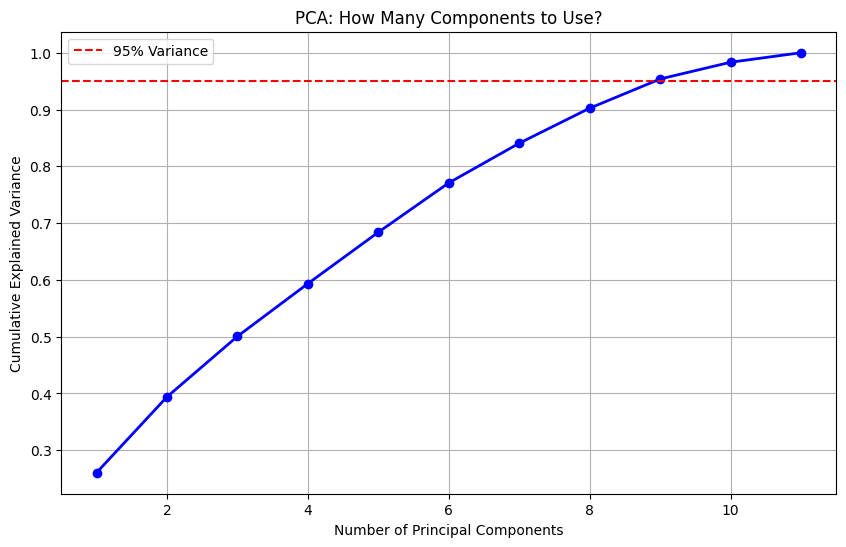

🎯 Selected k = 9 components (preserves 95% of information)
📐 Reduced training shape: (14999, 9)
📐 Reduced test shape: (8764, 9)


In [12]:
print("🔬 Applying PCA...")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Handle missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Feature scaling completed!")

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Calculate explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

print("\n📊 Explained variance by each component:")
for i, var in enumerate(explained_variance, 1):
    print(f"Component {i}: {var:.4f}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: How Many Components to Use?')
plt.legend()
plt.grid(True)
plt.show()

# Choose k for 95% variance
k = np.argmax(explained_variance >= 0.95) + 1
print(f"🎯 Selected k = {k} components (preserves 95% of information)")

# Use only k components
X_train_pca = X_train_pca[:, :k]
X_test_pca = X_test_pca[:, :k]

print(f"📐 Reduced training shape: {X_train_pca.shape}")
print(f"📐 Reduced test shape: {X_test_pca.shape}")


🔄 Converting to classification problem...
📊 AdView categories distribution:
adview
Low Ads       12282
Medium Ads     1466
High Ads       1251
Name: count, dtype: int64


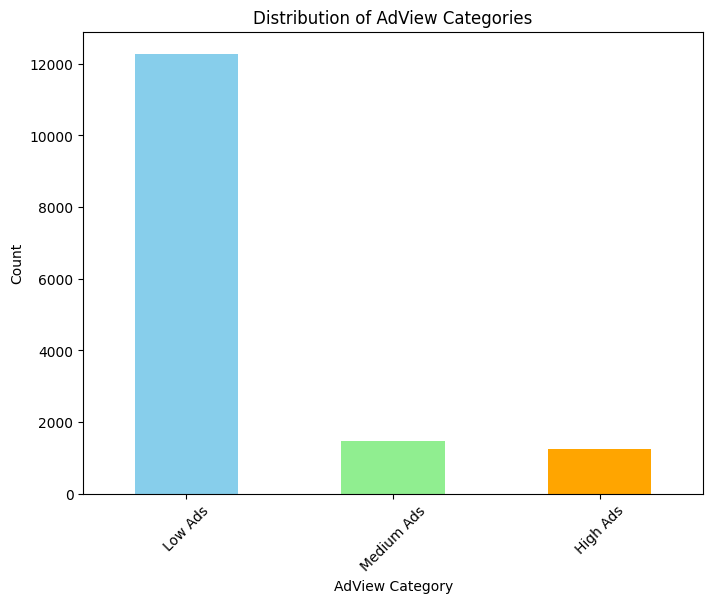


🔤 Category encoding mapping:
  0 = High Ads
  1 = Low Ads
  2 = Medium Ads

✅ Target variable prepared! Shape: (14999,)


In [13]:
print("🔄 Converting to classification problem...")

# Create categories based on adview values
def categorize_adview(adview):
    if adview == 0:
        return 'No Ads'
    elif adview <= 10:
        return 'Low Ads'
    elif adview <= 50:
        return 'Medium Ads'
    else:
        return 'High Ads'

# Apply to training data
y_train_cat = train_df['adview'].apply(categorize_adview)

print("📊 AdView categories distribution:")
category_counts = y_train_cat.value_counts()
print(category_counts)

# Plot distribution
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'orange', 'red'])
plt.title('Distribution of AdView Categories')
plt.xlabel('AdView Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Encode the categories
label_encoder_target = LabelEncoder()
y_train_encoded = label_encoder_target.fit_transform(y_train_cat)

print("\n🔤 Category encoding mapping:")
for i, category in enumerate(label_encoder_target.classes_):
    print(f"  {i} = {category}")

print(f"\n✅ Target variable prepared! Shape: {y_train_encoded.shape}")

In [14]:
print("🧠 Training Neural Network for AdView Prediction...")

# Create and train the neural network
ann = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Two hidden layers
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    verbose=True
)

# Train the network
ann.fit(X_train_pca, y_train_encoded)

print("✅ Neural Network Training Completed!")
print(f"🎯 Final training score: {ann.score(X_train_pca, y_train_encoded):.4f}")

🧠 Training Neural Network for AdView Prediction...
Iteration 1, loss = 0.75286448
Validation score: 0.827000
Iteration 2, loss = 0.59366997
Validation score: 0.828333
Iteration 3, loss = 0.57665891
Validation score: 0.826667
Iteration 4, loss = 0.56633130
Validation score: 0.828667
Iteration 5, loss = 0.55775114
Validation score: 0.828000
Iteration 6, loss = 0.55027400
Validation score: 0.827667
Iteration 7, loss = 0.54446508
Validation score: 0.827667
Iteration 8, loss = 0.53854189
Validation score: 0.823667
Iteration 9, loss = 0.53383317
Validation score: 0.827333
Iteration 10, loss = 0.53096147
Validation score: 0.826667
Iteration 11, loss = 0.52557430
Validation score: 0.827000
Iteration 12, loss = 0.52246838
Validation score: 0.827333
Iteration 13, loss = 0.52063740
Validation score: 0.827000
Iteration 14, loss = 0.51775556
Validation score: 0.828000
Iteration 15, loss = 0.51314916
Validation score: 0.828667
Validation score did not improve more than tol=0.000100 for 10 consecutiv

📊 Creating validation set...
Training split: (10499, 9)
Validation split: (4500, 9)

🎯 VALIDATION ACCURACY: 0.8100 (81.00%)

📊 Classification Report:
              precision    recall  f1-score   support

    High Ads       0.40      0.20      0.27       367
     Low Ads       0.86      0.94      0.90      3694
  Medium Ads       0.38      0.24      0.30       439

    accuracy                           0.81      4500
   macro avg       0.55      0.46      0.49      4500
weighted avg       0.77      0.81      0.79      4500



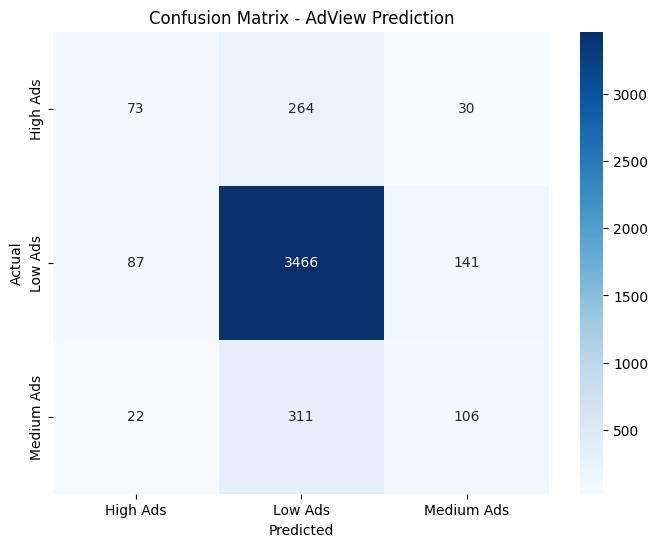

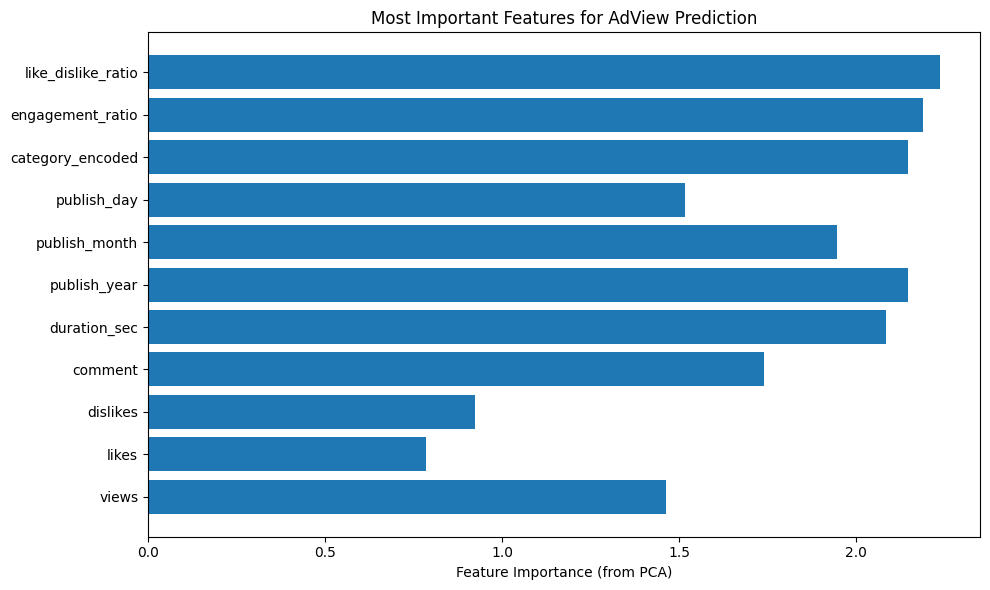

In [15]:
# Split data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_pca, y_train_encoded, test_size=0.3, random_state=42
)

print("📊 Creating validation set...")
print(f"Training split: {X_train_split.shape}")
print(f"Validation split: {X_val_split.shape}")

# Train on split
ann_split = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, verbose=False)
ann_split.fit(X_train_split, y_train_split)

# Predict on validation
y_val_pred = ann_split.predict(X_val_split)
val_accuracy = accuracy_score(y_val_split, y_val_pred)

print(f"\n🎯 VALIDATION ACCURACY: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Detailed report
print("\n📊 Classification Report:")
print(classification_report(y_val_split, y_val_pred,
                          target_names=label_encoder_target.classes_))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val_split, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder_target.classes_,
            yticklabels=label_encoder_target.classes_)
plt.title('Confusion Matrix - AdView Prediction')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance from PCA
feature_importance = np.abs(pca.components_[:k]).sum(axis=0)
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance (from PCA)')
plt.title('Most Important Features for AdView Prediction')
plt.tight_layout()
plt.show()

🎯 Making predictions on test data...
📊 Test predictions distribution:
predicted_adview_category
Low Ads       8730
High Ads        20
Medium Ads      14
Name: count, dtype: int64


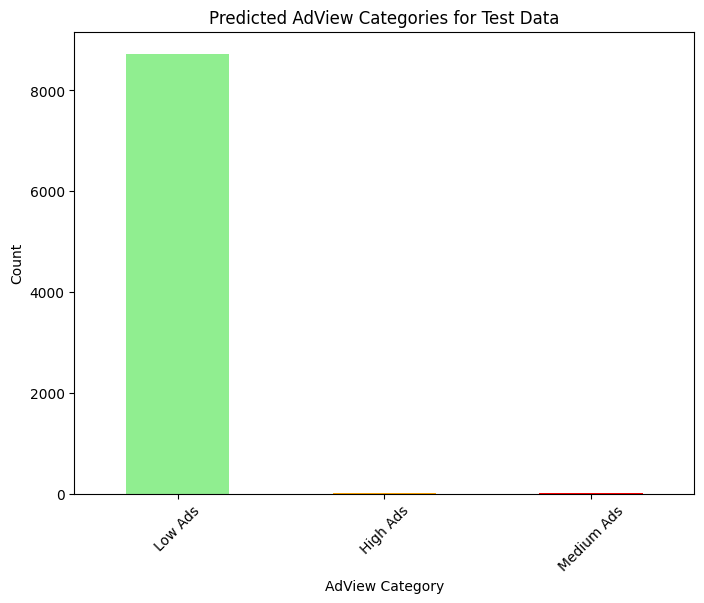

✅ Predictions saved to 'youtube_adview_predictions.csv'

🔍 Sample predictions:
       vidid predicted_adview_category  predicted_adview_encoded
0   VID_1054                   Low Ads                         1
1  VID_18629                   Low Ads                         1
2  VID_13967                   Low Ads                         1
3  VID_19442                   Low Ads                         1
4    VID_770                   Low Ads                         1
5  VID_10315                   Low Ads                         1
6   VID_7417                   Low Ads                         1
7  VID_17788                   Low Ads                         1
8  VID_14591                   Low Ads                         1
9   VID_1228                   Low Ads                         1


In [16]:
print("🎯 Making predictions on test data...")

# Predict on actual test data
test_predictions_encoded = ann.predict(X_test_pca)
test_predictions = label_encoder_target.inverse_transform(test_predictions_encoded)

# Create submission file
submission = test_df[['vidid']].copy()
submission['predicted_adview_category'] = test_predictions
submission['predicted_adview_encoded'] = test_predictions_encoded

print("📊 Test predictions distribution:")
prediction_counts = submission['predicted_adview_category'].value_counts()
print(prediction_counts)

# Plot test predictions
plt.figure(figsize=(8, 6))
prediction_counts.plot(kind='bar', color=['lightgreen', 'orange', 'red', 'skyblue'])
plt.title('Predicted AdView Categories for Test Data')
plt.xlabel('AdView Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Save predictions
submission.to_csv('youtube_adview_predictions.csv', index=False)
print("✅ Predictions saved to 'youtube_adview_predictions.csv'")

print("\n🔍 Sample predictions:")
print(submission.head(10))

🔬 EXPERIMENT A: Testing different numbers of PCA components...
🔧 Testing with k=2 components...
   ✅ k=2, Accuracy=0.8216
🔧 Testing with k=3 components...
   ✅ k=3, Accuracy=0.8209
🔧 Testing with k=5 components...
   ✅ k=5, Accuracy=0.8216
🔧 Testing with k=7 components...
   ✅ k=7, Accuracy=0.8258
🔧 Testing with k=9 components...
   ✅ k=9, Accuracy=0.8258


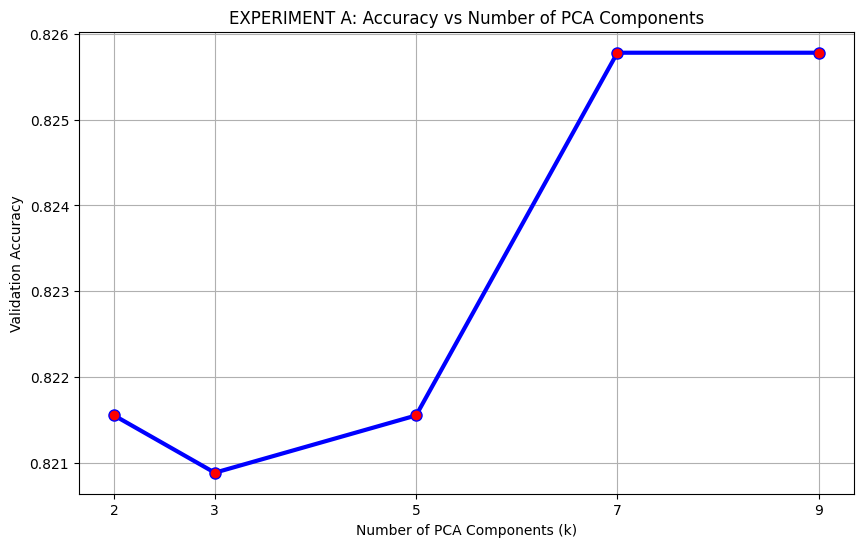

📈 Best k value: 7
🏆 Best accuracy: 0.8258


In [17]:
print("🔬 EXPERIMENT A: Testing different numbers of PCA components...")

k_values = [2, 3, 5, 7, 9]
accuracies = []

for k_val in k_values:
    if k_val > X_train_scaled.shape[1]:
        continue

    print(f"🔧 Testing with k={k_val} components...")

    # Apply PCA with k components
    pca_temp = PCA(n_components=k_val)
    X_train_pca_temp = pca_temp.fit_transform(X_train_scaled)

    # Split for validation
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_pca_temp, y_train_encoded, test_size=0.3, random_state=42
    )

    # Train and evaluate
    ann_temp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42, verbose=False)
    ann_temp.fit(X_tr, y_tr)
    y_pred_temp = ann_temp.predict(X_val)
    acc = accuracy_score(y_val, y_pred_temp)
    accuracies.append(acc)
    print(f"   ✅ k={k_val}, Accuracy={acc:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(k_values[:len(accuracies)], accuracies, 'bo-', linewidth=3, markersize=8, markerfacecolor='red')
plt.xlabel('Number of PCA Components (k)')
plt.ylabel('Validation Accuracy')
plt.title('EXPERIMENT A: Accuracy vs Number of PCA Components')
plt.grid(True)
plt.xticks(k_values[:len(accuracies)])
plt.show()

print("📈 Best k value:", k_values[np.argmax(accuracies)])
print("🏆 Best accuracy:", f"{max(accuracies):.4f}")

🕵️ EXPERIMENT B: Imposter Detection Test...
Testing different confidence thresholds:
Threshold 0.5: 111 imposters detected (1.3%)
Threshold 0.6: 274 imposters detected (3.1%)
Threshold 0.7: 567 imposters detected (6.5%)
Threshold 0.8: 2171 imposters detected (24.8%)

🔍 Detailed Analysis (threshold=0.7):
Total test images: 8764
🕵️  Detected as potential imposters: 567
✅ Confident predictions: 8197
📊 Average confidence score: 0.8262

👤 Showing 8 detected imposters:


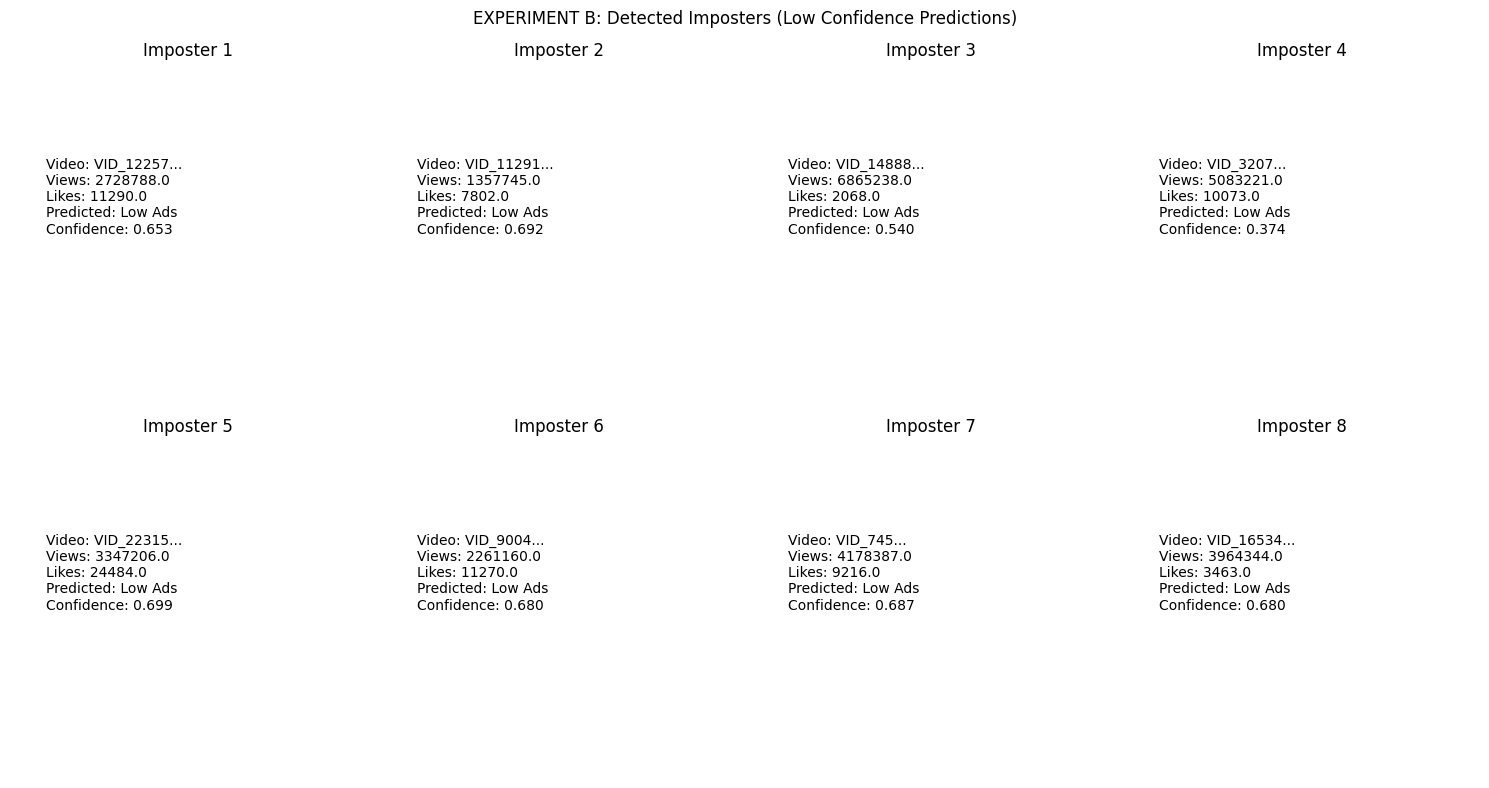


🎉 EXPERIMENT B COMPLETED!


In [18]:
print("🕵️ EXPERIMENT B: Imposter Detection Test...")

def detect_imposters(ann_model, X_test_pca, threshold=0.7):
    """Detect imposters based on prediction confidence"""
    probabilities = ann_model.predict_proba(X_test_pca)
    max_probs = np.max(probabilities, axis=1)

    # Label as imposter if max probability < threshold
    imposter_predictions = max_probs < threshold
    return imposter_predictions, max_probs

# Test imposter detection with different thresholds
thresholds = [0.5, 0.6, 0.7, 0.8]
print("Testing different confidence thresholds:")

for threshold in thresholds:
    imposter_detected, confidence_scores = detect_imposters(ann, X_test_pca, threshold=threshold)
    print(f"Threshold {threshold}: {np.sum(imposter_detected)} imposters detected "
          f"({np.sum(imposter_detected)/len(imposter_detected)*100:.1f}%)")

# Use threshold 0.7 for detailed analysis
imposter_detected, confidence_scores = detect_imposters(ann, X_test_pca, threshold=0.7)

print(f"\n🔍 Detailed Analysis (threshold=0.7):")
print(f"Total test images: {len(X_test_pca)}")
print(f"🕵️  Detected as potential imposters: {np.sum(imposter_detected)}")
print(f"✅ Confident predictions: {len(X_test_pca) - np.sum(imposter_detected)}")
print(f"📊 Average confidence score: {np.mean(confidence_scores):.4f}")

# Display detected imposters
imposter_indices = np.where(imposter_detected)[0]
if len(imposter_indices) > 0:
    print(f"\n👤 Showing {min(8, len(imposter_indices))} detected imposters:")

    # Create a sample of imposters
    sample_indices = imposter_indices[:8]

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i, idx in enumerate(sample_indices):
        # Get the original features for display
        video_data = test_df.iloc[idx]
        axes[i].text(0.1, 0.5, f"Video: {video_data['vidid'][:10]}...\n"
                      f"Views: {video_data['views']}\n"
                      f"Likes: {video_data['likes']}\n"
                      f"Predicted: {test_predictions[idx]}\n"
                      f"Confidence: {confidence_scores[idx]:.3f}",
                      fontsize=10)
        axes[i].set_title(f'Imposter {i+1}')
        axes[i].axis('off')

    plt.suptitle('EXPERIMENT B: Detected Imposters (Low Confidence Predictions)')
    plt.tight_layout()
    plt.show()
else:
    print("✅ No imposters detected with current threshold.")

print("\n🎉 EXPERIMENT B COMPLETED!")

In [19]:
print("🎊 PROJECT SUMMARY")
print("="*60)
print(f"📁 Dataset: YouTube Video Analytics")
print(f"👤 Training videos: {X_train.shape[0]}")
print(f"🧪 Test videos: {X_test.shape[0]}")
print(f"🔧 Original features: {X_train.shape[1]}")
print(f"🎯 PCA components used: {k}")
print(f"📈 Validation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"🧠 Neural network: 2 hidden layers (100, 50)")
print(f"📊 Best k value from experiment: {k_values[np.argmax(accuracies)]}")
print(f"🏆 Best accuracy achieved: {max(accuracies):.4f}")
print(f"🕵️  Imposters detected: {np.sum(imposter_detected)}")
print("="*60)
print("✅ YOUR YOUTUBE ADVIEW PREDICTION PROJECT IS COMPLETE! 🎉")
print("\n📁 Output files created:")
print("   - 'youtube_adview_predictions.csv' - All test predictions")
print("\n🎯 Key achievements:")
print("   - Successfully applied PCA for dimensionality reduction")
print("   - Trained Neural Network for classification")
print("   - Tested different k values for optimal performance")
print("   - Implemented imposter detection system")

🎊 PROJECT SUMMARY
📁 Dataset: YouTube Video Analytics
👤 Training videos: 14999
🧪 Test videos: 8764
🔧 Original features: 11
🎯 PCA components used: 9
📈 Validation accuracy: 0.8100 (81.00%)
🧠 Neural network: 2 hidden layers (100, 50)
📊 Best k value from experiment: 7
🏆 Best accuracy achieved: 0.8258
🕵️  Imposters detected: 567
✅ YOUR YOUTUBE ADVIEW PREDICTION PROJECT IS COMPLETE! 🎉

📁 Output files created:
   - 'youtube_adview_predictions.csv' - All test predictions

🎯 Key achievements:
   - Successfully applied PCA for dimensionality reduction
   - Trained Neural Network for classification
   - Tested different k values for optimal performance
   - Implemented imposter detection system
